### Part B

In this part, we implemented the Route-First, Cluster-Second approach. We used two different TSP tour construction methods:
- **Christofides Algorithm**
- **Nearest Neighbor**

Each solution was split into feasible VRP routes based on vehicle capacity (85 units). Then, two improvement heuristics were applied:
- **Relocate** to Christofides-based routes
- **2-opt** to Nearest Neighbor-based routes

We also computed the % improvement and times over the base solution for both methods, and summarized them in a table. And confirmed that all solutions are feasible.




In [88]:
!pip install ipynb

In [89]:
from scipy.cluster.vq import kmeans2, whiten
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import networkx as nx

from ipynb.fs.full.TSPlib import two_opt,christofides
from ipynb.fs.full.TSPlib import nearest_neighbor
from ipynb.fs.full.TSPlib import relocate, savings
from ipynb.fs.full.VRPlib import CFRS, RFCS


In [90]:
# Load Excel data
file_path = "Spring25Project_Data.xlsx"
df_demands = pd.read_excel(file_path, sheet_name='demands')
df_coordinates = pd.read_excel(file_path, sheet_name='coordinates')
# Extract coordinates as (x, y) pairs
coordinates = df_coordinates[['x-coordinate', 'y-coordinate']].values
# Extract demand values as a NumPy array
demands = df_demands['Demand'].values

In [91]:
df_coordinates

,Node ID,x-coordinate,y-coordinate
0,0,39,19
1,1,79,19
2,2,41,79
3,3,25,31
4,4,63,93
5,5,33,5
6,6,69,17
7,7,57,73
8,8,53,75
9,9,1,1


#**Euclidian Distance**

In [92]:
import math

lat = df_coordinates["y-coordinate"]
lon = df_coordinates["x-coordinate"]

# Calculate the average latitude
mean_lat = lat.mean()

# 1 degree of latitude is approximately 111320 meters
meters_per_deg_lat = 111320

# 1 degree of longitude is approximately 111320 * cos(average latitude) meters
meters_per_deg_lon = 111320 * math.cos(math.radians(mean_lat))

# Transform coordinates relative to a reference point
df_coordinates["x_m"] = (lon - lon.min()) * meters_per_deg_lon
df_coordinates["y_m"] = (lat - lat.min()) * meters_per_deg_lat

# Convert the transformed coordinates (in meters) to a numpy array
coords_m = df_coordinates[['x_m', 'y_m']].values

# Compute the distance matrix using numpy broadcasting
d = np.sqrt(((coords_m[:, None, :] - coords_m[None, :, :]) ** 2).sum(axis=2))



In [93]:
#demands are from the excel sheet,defined at the beginning
veh_cap = 85
total_demand = sum(demands)
k = math.ceil(total_demand/veh_cap) # number of vehicles available

print("Total demand:", total_demand)
print("Vehicle capacity:", veh_cap)
print("Estimated number of vehicles:", k)

Total demand: 526
Vehicle capacity: 85
Estimated number of vehicles: 7


In [94]:
nodes = list(range(df_coordinates.shape[0]))

In [95]:
node_coordinates = {i: (df_coordinates["x-coordinate"][i], df_coordinates["y-coordinate"][i])
                    for i in nodes}

In [96]:
x, y = kmeans2(whiten(coordinates), k, iter = 100)

/usr/local/lib/python3.11/dist-packages/scipy/_lib/_util.py:440: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  return fun(*args, **kwargs)


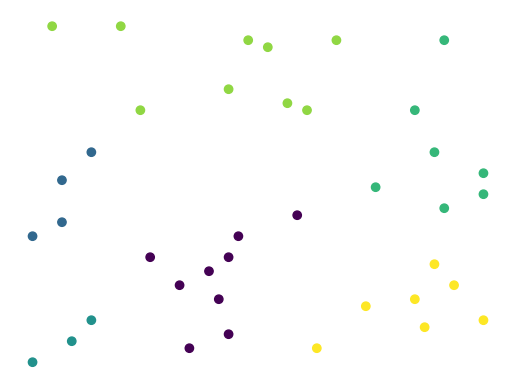

In [97]:
plt.scatter(coordinates[:,0], coordinates[:,1], c = y)
plt.axis('off')
plt.show()

# **RFCS with Christofides algorithm**

In [98]:
# Start timing
start_time = time.time()

vrp_solution, total_length = RFCS(coordinates, d, demands, veh_cap, method='christofides')


# End timing
end_time = time.time()
runtime_RFCS_C = end_time - start_time
print(f"\n Total runtime for RFCS: {runtime_RFCS_C:.4f} seconds")


 Total runtime for RFCS: 0.0135 seconds


In [99]:
print("The VRP solution obtained by RFCS procedure:\n", vrp_solution, "with a"
      " total length of", total_length)

The VRP solution obtained by RFCS procedure:
 [[0, 1, 26, 5, 9, 28, 29, 0], [0, 24, 15, 0], [0, 13, 30, 0], [0, 20, 32, 18, 22, 34, 27, 10, 7, 8, 0], [0, 2, 35, 25, 33, 19, 0], [0, 16, 4, 14, 31, 37, 38, 0], [0, 12, 3, 11, 6, 0], [0, 36, 17, 21, 23, 0]] with a total length of 106118215.32


# **Applying Relocate algorithm to RFCS-Christofides solution**



In [100]:
#apply Relocate

# Start timing
start_time = time.time()


improved_solution_reloc = []
improved_cost_reloc = 0

for route in vrp_solution:
    if route[0] == 0 and route[-1] == 0:
        core = route[1:-1]
    else:
        core = route

    improved_route, cost = relocate([0] + core + [0], depot=0, d=d)
    improved_solution_reloc.append(improved_route)
    improved_cost_reloc += cost

print("\n Christofides + Relocation Results:")
for i, route in enumerate(improved_solution_reloc):
    print(f"Route {i+1}: {route}")
print("Total cost after Relocation:", improved_cost_reloc)

# End timing
end_time = time.time()

runtime_RFCS_relocate = end_time - start_time
print(f"\n Total runtime for RFCS + Relocate algorithm: {runtime_RFCS_relocate:.4f} seconds")



 Christofides + Relocation Results:
Route 1: [0, 1, 26, 5, 9, 28, 29, 0]
Route 2: [0, 24, 15, 0]
Route 3: [0, 13, 30, 0]
Route 4: [0, 20, 32, 18, 22, 34, 27, 10, 7, 8, 0]
Route 5: [0, 35, 25, 33, 19, 2, 0]
Route 6: [0, 16, 4, 14, 31, 37, 38, 0]
Route 7: [0, 12, 3, 6, 11, 0]
Route 8: [0, 36, 17, 23, 21, 0]
Total cost after Relocation: 103949916.89404477

 Total runtime for RFCS + Relocate algorithm: 0.0024 seconds


# **RFCS with Nearest Neighbor algorithm**

In [101]:
# Start timing
start_time = time.time()

vrp_solution_NN, total_length_NN = RFCS(coordinates, d, demands, veh_cap,method='nearest_neighbor')


# End timing
end_time = time.time()
runtime_RFCS_NN = end_time - start_time
print(f"\n Total runtime for RFCS: {runtime_RFCS_NN:.4f} seconds")

Added 24 to the tour!
Added 15 to the tour!
Added 13 to the tour!
Added 30 to the tour!
Added 20 to the tour!
Added 32 to the tour!
Added 18 to the tour!
Added 22 to the tour!
Added 34 to the tour!
Added 27 to the tour!
Added 10 to the tour!
Added 7 to the tour!
Added 8 to the tour!
Added 2 to the tour!
Added 19 to the tour!
Added 33 to the tour!
Added 4 to the tour!
Added 16 to the tour!
Added 25 to the tour!
Added 35 to the tour!
Added 14 to the tour!
Added 31 to the tour!
Added 37 to the tour!
Added 38 to the tour!
Added 12 to the tour!
Added 3 to the tour!
Added 29 to the tour!
Added 28 to the tour!
Added 9 to the tour!
Added 5 to the tour!
Added 26 to the tour!
Added 11 to the tour!
Added 6 to the tour!
Added 1 to the tour!
Added 23 to the tour!
Added 21 to the tour!
Added 17 to the tour!
Added 36 to the tour!

 Total runtime for RFCS: 0.0020 seconds


# **Applying Two-opt algorithm to RFCS-NearestNeighbor solution**



In [102]:
#applying two-opt

# Start timing
start_time = time.time()


depot=0
improved_solution_2opt = []
improved_cost_2opt = 0

for route in vrp_solution_NN:
    if route[0] == 0 and route[-1] == 0:
        core = route[1:-1]
    else:
        core = route

    new_core, _ = two_opt(core, depot, d)
    new_route = [0] + new_core + [0]
    cost = sum(d[new_route[i]][new_route[i+1]] for i in range(len(new_route)-1))

    improved_solution_2opt.append(new_route)
    improved_cost_2opt += cost

print("\n Nearest Neighbor + 2-opt Results:")
for i, route in enumerate(improved_solution_2opt):
    print(f"Route {i+1}: {route}")
print("Total cost after 2-opt:", improved_cost_2opt)

# End timing
end_time = time.time()

runtime_RFCS_twoopt = end_time - start_time
print(f"\n Total runtime for RFCS + 2-opt Algorithm: {runtime_RFCS_twoopt:.4f} seconds")


Attempting to improve the tour [24, 15] with length 0

Attempting to improve the tour [13, 30] with length 0

Attempting to improve the tour [20, 32, 18, 22, 34, 27, 10, 7, 8] with length 0
Cost difference due to swapping 32 and 18 is: 1806428.95
Cost difference due to swapping 32 and 22 is: 2645680.9
Cost difference due to swapping 32 and 34 is: 2162558.43
Cost difference due to swapping 32 and 27 is: 2593099.06
Cost difference due to swapping 32 and 10 is: 3247007.03
Cost difference due to swapping 32 and 7 is: 4438776.65
Cost difference due to swapping 18 and 22 is: 1069384.13
Cost difference due to swapping 18 and 34 is: 1255299.18
Cost difference due to swapping 18 and 27 is: 1951121.53
Cost difference due to swapping 18 and 10 is: 3324716.74
Cost difference due to swapping 18 and 7 is: 5195027.64
Cost difference due to swapping 22 and 34 is: 1025528.8
Cost difference due to swapping 22 and 27 is: 2534270.31
Cost difference due to swapping 22 and 10 is: 4544066.38
Cost difference

# Function,
# for checking the vehcile capacity,
# for visiting every vertex once,
# for starting and ending the tour at zero(depot)


In [103]:
def verify_solution(routes, demands, vehicle_capacity):
    all_customers = set()
    valid = True

    for idx, route in enumerate(routes):
        if route[0] != 0 or route[-1] != 0:
            print(f" Route {idx+1} does not start/end at depot.")
            valid = False

        # Remove depot entries to count only customers
        customers = [node for node in route if node != 0]

        demand = sum(demands[c] for c in customers)
        if demand > vehicle_capacity:
            print(f" Route {idx+1} exceeds capacity: {demand} > {vehicle_capacity}")
            valid = False

        all_customers.update(customers)

    expected_customers = set(range(1, len(demands)))  # excluding the depot, zero
    if all_customers != expected_customers:
        missing = expected_customers - all_customers
        extra = all_customers - expected_customers
        print(f" Customer mismatch. Missing: {missing}, Extra: {extra}")
        valid = False

    if valid:
        print(" All routes are valid!")
    return valid


print("\n Verifying Base RFCS + NN Solution:")
verify_solution(vrp_solution_NN, demands, veh_cap)

print("\n Verifying Relocation Improved Solution:")
verify_solution(improved_solution_reloc, demands, veh_cap)

print("\n Verifying 2-opt Improved Solution:")
verify_solution(improved_solution_2opt, demands, veh_cap)




 Verifying Base RFCS + NN Solution:
 All routes are valid!

 Verifying Relocation Improved Solution:
 All routes are valid!

 Verifying 2-opt Improved Solution:
 All routes are valid!


True

In [104]:
# Calculate improvements
improve_reloc = ((total_length - improved_cost_reloc) / total_length) * 100
improve_2opt = ((total_length_NN - improved_cost_2opt) / total_length_NN) * 100

print("\n Final Comparison Table (Part B):")
print("{:<45} {:<10} {:<10} {:<12}".format("Combination", "Cost", "% Improve", "Time (s)"))
print("_" * 80)
print("{:<45} {:<10.2f} {:<10.2f} {:<12.4f}".format("RFCS + Christofides", total_length, 0.00, runtime_RFCS_C))
print("{:<45} {:<10.2f} {:<10.2f} {:<12.4f}".format("RFCS + Christofides + Relocate", improved_cost_reloc, improve_reloc, runtime_RFCS_C + runtime_RFCS_relocate))
print("{:<45} {:<10.2f} {:<10.2f} {:<12.4f}".format("RFCS + Nearest Neighbor", total_length_NN, 0.00, runtime_RFCS_NN))
print("{:<45} {:<10.2f} {:<10.2f} {:<12.4f}".format("RFCS + Nearest Neighbor + 2-opt", improved_cost_2opt, improve_2opt, runtime_RFCS_NN + runtime_RFCS_twoopt))



 Final Comparison Table (Part B):
Combination                                   Cost       % Improve  Time (s)    
________________________________________________________________________________
RFCS + Christofides                           106118215.32 0.00       0.0135      
RFCS + Christofides + Relocate                103949916.89 2.04       0.0159      
RFCS + Nearest Neighbor                       101142323.85 0.00       0.0020      
RFCS + Nearest Neighbor + 2-opt               100962383.69 0.18       0.0039      
